# Time Serie Analisys

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import datetime
import seaborn as sns


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


import warnings 
warnings.filterwarnings('ignore')

In [20]:
path = 'analise-de-serie-temporal-master/dados_clima.csv'

class setup(object):
    def __init__(self, path:str):
        self.path = path
        self.data_raw = pd.read_csv(self.path)
        
    def get_data(self):
        self.data = self.data_raw.copy(deep=True)
        self.data.data = self.data.data.apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y')) #Aplica formato datetime
        return self.data
    
    def info_plis(self, print_info:bool=False):
        if print_info ==True:
            print(self.data.info())
            print('*'*50)
            print(self.data.columns)
            print('*'*50)
            print('Shape:' ,self.data.shape)
        else:
            self.data.head(5)
    
            
            
a = setup(path)
data = a.get_data()
a.info_plis(print_info=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214166 entries, 0 to 214165
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Estacao       214166 non-null  int64         
 1   altitude      214166 non-null  float64       
 2   cidade        214166 non-null  object        
 3   data          214166 non-null  datetime64[ns]
 4   estado        214166 non-null  object        
 5   fonte         214166 non-null  object        
 6   insolacao     211951 non-null  float64       
 7   latitude      214166 non-null  float64       
 8   longitude     214166 non-null  float64       
 9   precipitacao  214165 non-null  float64       
 10  tmax          214166 non-null  float64       
 11  tmin          214165 non-null  float64       
 12  ur            214166 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 21.2+ MB
None
*************************************

# Note que:
* Estacao, Altitude, cidade, estado, latitude, longitude: Sao Features de localizacao
* data, estacao : Feature de Tempo
* precipitacao, tmax, tmin, ur: Feature Fisicos (permitem modelagem)
* fonte: Feature inutil

precipitacao
tmax
tmin
ur


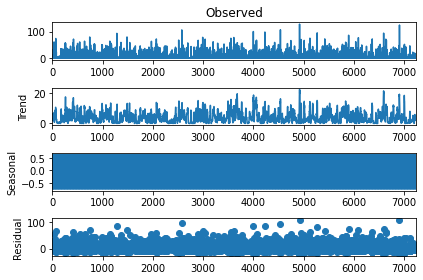

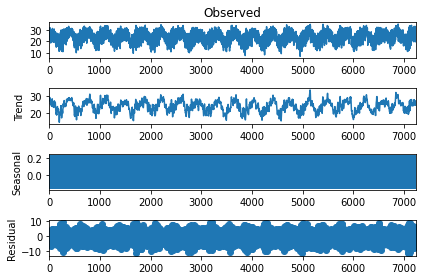

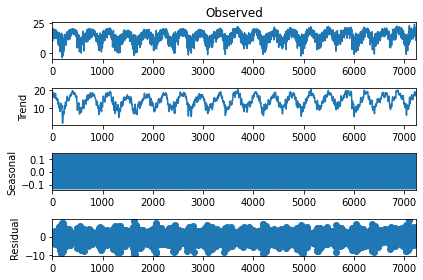

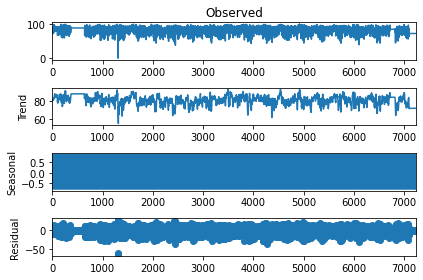

In [104]:
geo_features = ['cidade', 'estado']
time_features = ['date', 'estacao']
physic_features = ['precipitacao', 'tmax', 'tmin', 'ur']
data.groupby(geo_features)['data','precipitacao','tmax','tmin','ur'].agg({'data':['min','max'], 'precipitacao':'mean'})


class time_analisys(setup):
    def __init__(self):
        super().__init__(path)
        
    def group_table(self, show_plis:bool=False):
        grouped = data.groupby(geo_features)['data','precipitacao','tmax','tmin','ur'].agg({'data':['min','max'], 'precipitacao':'mean'})
        if show_plis==True:
            print(grouped.head())
        return grouped
        
    def group_city(self, city:str):
        self.city = str(city)
        self.city_1 = data.loc[data.cidade==self.city]
        
    def plot_plis(self, plot_ts:bool=False, plot_sm:bool=False, plot_sm_2:bool=False):
        for var in physic_features:
            ts = self.city_1.groupby(['data'])[var].sum()
            ts.astype('float')
            if plot_ts==True:
                plt.figure(figsize=(12,6))
                plt.title(var)
                plt.plot(ts, ':g')
                plt.show()
            if plot_sm==True:
                try:
                    res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
                    print(var)
                    fig = res.plot()
                except:
                    pass
            if plot_sm_2==True:
                try:
                    res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='additive')
                    print(var)
                    fig = res.plot()
                    fig.show()
                except:
                    pass
        return ts
b = time_analisys()
c = b.group_table()
b.group_city('curitiba')
ts = b.plot_plis(plot_sm_2=True)

### Note que:

* No modelo aditivo, podemos considerar:
    $$ y(t) = S(t) + T(t) + E(t) $$
    onde:
        * y(t) sao dos dados no periodo t
        * S(t) sao os componentem seasonal no periodo t
        * T(t) sao os trend-cycle no periodo t
        * E(t) sao os erros no periodo t
        

* No modelo multiplicativo, podemos considerar:
    $$ y(t) = S(t) * T(t) * E(t) $$
    


## Stationarity - Modelo estacionario

1. Os dados serem Estacionarios significam que a media das series nao deve ser uma funcao do tempo.
2. A variancia da serie nao deve ser uma funcao do tempo
3. A covarianca de n-nesimo e n+m-nesimo termo nao deve ser uma funcao do tempo.

Uma variavel estacionaria e invariante pelo tempo.

### Testes de estacionaridade

1. ADF (Augmented Dicky Fuller Test)
2. KPSS
3. PP(Phillips-Perron test)

In [105]:

def test_stationarity(timeseries):
    print('Resultados do test Dickey-Fuller:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
        print (df_output)
        
test_stationarity(ts)

Resultados do test Dickey-Fuller:
Test Statistic                -9.864322e+00
p-value                        4.152790e-17
#Lags Used                     3.400000e+01
Number of Observations Used    7.203000e+03
Critical Value (1%)           -3.431258e+00
dtype: float64
Test Statistic                -9.864322e+00
p-value                        4.152790e-17
#Lags Used                     3.400000e+01
Number of Observations Used    7.203000e+03
Critical Value (1%)           -3.431258e+00
Critical Value (5%)           -2.861941e+00
dtype: float64
Test Statistic                -9.864322e+00
p-value                        4.152790e-17
#Lags Used                     3.400000e+01
Number of Observations Used    7.203000e+03
Critical Value (1%)           -3.431258e+00
Critical Value (5%)           -2.861941e+00
Critical Value (10%)          -2.566984e+00
dtype: float64
